The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


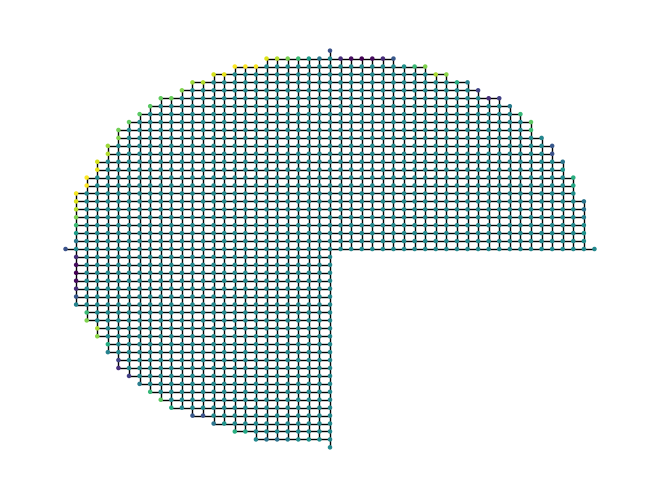

In [99]:
# %%
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import numba
import matplotlib.cm as cm
from scipy.sparse import csr_matrix
from Solver import Solve
# %%
%load_ext autoreload
%autoreload 2


# Define the range
r = 0.5
theta_min = 0
theta_max = math.pi/3

# signal= theta_node (theta_max-theta_node), np.sin(theta_node (theta_max-theta_node))

length=200
# Create a grid graph
G = nx.grid_2d_graph(length,length)
# Create positions for each node
pos = {(x,y):(8*x/length-4, 8*y/length-4) for x,y in G.nodes()}


Sub_nodes = []
perimter_nodes = []
for node in list(G.nodes()):  # Use list(G.nodes()) to create a copy of the nodes list, because you can't modify a list while iterating over it
    x, y = pos[node]
    r_node, theta_node = math.sqrt(x**2 + y**2), np.select([y>=0,y<0],[np.arctan2(y,x),np.arctan2(y,x)+2*math.pi,])   
    if r_node <= r and theta_min <= theta_node <= theta_max:      
        Sub_nodes.append(node)
    elif G.degree(node) < 4:
        perimter_nodes.append(node)    

# Create the subgraph
Sub_G = G.subgraph(Sub_nodes)

# Create a dictionary for the signals
signals = {}

# Calculate the signals
subgraph_pos = {node: pos[node] for node in Sub_G.nodes()}  # Get the positions of the nodes in the subgraph

internal_nodes=[]
boundary_nodes=[]
for node in Sub_G.nodes():
    x, y = subgraph_pos[node]
    if Sub_G.degree(node) < 4:
        theta_node = np.select([y>=0,y<0],[np.arctan2(y,x),np.arctan2(y,x)+2*math.pi,]) 
        r_node = math.sqrt(x**2 + y**2)
        if 0.000001*theta_max+theta_min <= theta_node <= theta_max-0.000001*theta_max and r_node>r*0.7 :
            signals[node] = theta_node*(theta_max-theta_node)*np.sin(5*theta_node*(theta_max-theta_node))
            boundary_nodes.append(node)
        else:
            signals[node] = 0
            boundary_nodes.append(node)
    else:
        internal_nodes.append(node)

for i in perimter_nodes:
    signals[i] = 0

# Get the signal values
node_colors = [signals.get(node, 0) for node in Sub_G.nodes()]  # Use 0 for nodes that were not assigned a signal

# Draw the nodes of the subgraph with colors based on the signal
nx.draw(Sub_G, pos, node_color=node_colors, node_size=5, cmap=plt.cm.viridis)
plt.show()
# %%

bound_G_nodes = set(G.nodes()) - set(internal_nodes) 
bound_G = G.subgraph(bound_G_nodes)
# Create a new position dictionary for bound_G
bound_G_pos = {node: pos[node] for node in bound_G.nodes()}

# Assume node_to_index is a dictionary that maps nodes to their indices
node_to_index = {node: index for index, node in enumerate(bound_G.nodes())}

# Create an array of boundary nodes indices in U
bounds = np.array([node_to_index[node] for node in boundary_nodes+perimter_nodes])

# Calculate the Laplacian matrix of bound_G
L = nx.laplacian_matrix(bound_G)


# %%


In [103]:
# %%

node_to_index = {node: i for i, node in enumerate(bound_G.nodes())}
x_bound = []

for i in boundary_nodes+perimter_nodes:
    x_bound.append(signals[i]) 

x_bound = np.array(x_bound)

U,loss=Solve(x_bound,bounds, L, alpha=10, learning_rate=0.5, num_iter=10000, verbose=True, convergence_threshold=1e-9,loss=True)




Iteration: 0, Loss: 5839111.201856161
Iteration: 10, Loss: 257523.5221821442
Iteration: 20, Loss: 1160.4143238298961
Iteration: 30, Loss: 104.74087511289807
Iteration: 40, Loss: 52.97479620189271
Iteration: 50, Loss: 40.51541555452267
Iteration: 60, Loss: 36.005141074266255
Iteration: 70, Loss: 34.160260378643606
Iteration: 80, Loss: 33.33868242971455
Iteration: 90, Loss: 32.9419482504383
Iteration: 100, Loss: 32.73325309925573
Iteration: 110, Loss: 32.612639115277325
Iteration: 120, Loss: 32.53549571740998
Iteration: 130, Loss: 32.48091482800014
Iteration: 140, Loss: 32.43866164699889
Iteration: 150, Loss: 32.40352534516425
Iteration: 160, Loss: 32.37275468535168
Iteration: 170, Loss: 32.34484558258877
Iteration: 180, Loss: 32.318946665650834
Iteration: 190, Loss: 32.29455820525359
Iteration: 200, Loss: 32.2713750988658
Iteration: 210, Loss: 32.249202782790725
Iteration: 220, Loss: 32.22791109396057
Iteration: 230, Loss: 32.207408380005454
Iteration: 240, Loss: 32.18762666230348
Itera

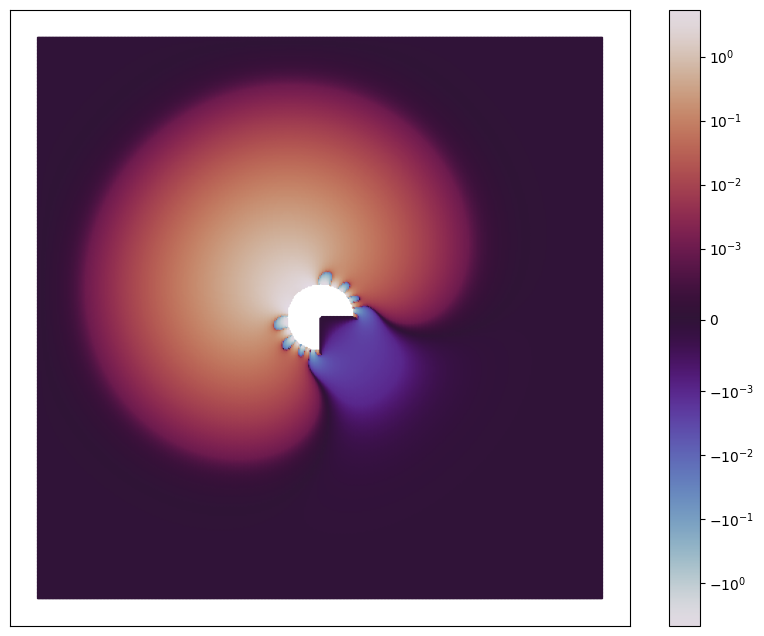

In [110]:
import matplotlib.colors as colors
import numpy as np

# Create a new figure with specified size (width, height)
fig, ax = plt.subplots(figsize=(10, 8))

# Create a SymLogNorm object
norm = colors.SymLogNorm(linthresh=0.001)

# Normalize the node colors
node_colors = norm(U)

# Draw the nodes with normalized colors
cc = nx.draw_networkx_nodes(bound_G, pos=bound_G_pos, node_color=node_colors, node_size=1, cmap=plt.cm.twilight)

# Create a new scalar mappable
sm = plt.cm.ScalarMappable(cmap=cc.cmap, norm=norm)
sm.set_array([])

# Add the color bar
plt.colorbar(sm, ax=ax)

# Save the plot as an SVG file
plt.savefig("3rdpi.png", format='png')

# Show the plot
plt.show()

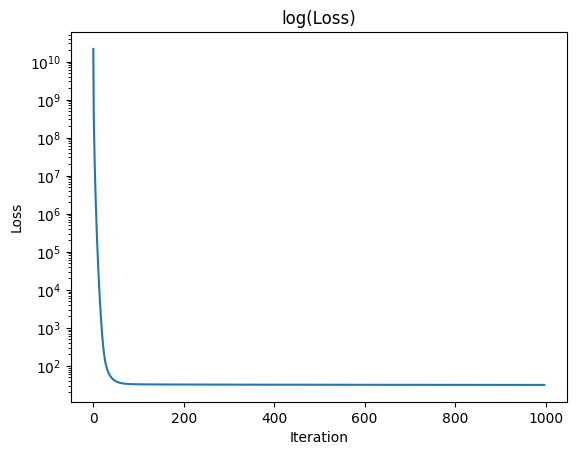

In [113]:
plt.plot((loss[2:1000]))
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.title('log(Loss)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.savefig("loss.png", format='png')
plt.show()